In [55]:
import cv2
import glob
import numpy as np
from scipy.ndimage import rotate
import os

from matplotlib.pyplot import imshow
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [20, 10]

In [56]:
def select1(img_no):
    
    filelist = sorted(glob.glob('C:\\Users\\user\\Desktop\\DATASET\\Original%20Images\\*.JPG'))
    img_bgr = cv2.imread(filelist[img_no])
    # y=filelist[img_no]
    # x=y[48:]
    # print(x)
    
    return img_bgr
def find_name(img_no):
    filelist = sorted(glob.glob('C:\\Users\\user\\Desktop\\DATASET\\Original%20Images\\*.JPG'))
    y=filelist[img_no]
    x=y[48:]
    print(x)
    return x

def select2(img_no):
    filelist2 = sorted(glob.glob('C:\\Users\\user\\Desktop\\DATASET\\Meibomian Gland Labels\\*.png'))
    img_bgr2 = cv2.imread(filelist2[img_no])
    # print(filelist2[img_no])
    img2 = cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2GRAY)
    return img2


def define_images(img_no):
    img_bgr= select1(img_no)# original photo from dataset
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY) #gray form of original image
    img2= select2(img_no)#target labeled gland
    return img_bgr,img,img2








In [57]:
def mask_img(input, mask):
    return ((mask/255)*input).astype(np.uint8)


def mask_blend(input, mask):
    return cv2.addWeighted(input, 1, mask, 0.25, 0)


def imfill(input):
    output = np.zeros(input.shape, dtype=np.uint8)
    cnts, _ = cv2.findContours(input, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(output, cnts, -1, 255, thickness=cv2.FILLED)
    return output


def calcParams(input):
    cnt, _ = cv2.findContours(input, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    _, (l, _), _ = cv2.minAreaRect(cnt[0])
    t_arr = np.sum(input, axis=1)/255
    t_std = np.std(t_arr[np.nonzero(t_arr)])
    t_mean = np.mean(t_arr[np.nonzero(t_arr)])
    return (l, t_std, t_mean)


def skeleton(input):
    size = np.size(input)
    strel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    skel = np.zeros(input.shape, np.uint8)

    done = False
    while (not done):
        eroded = cv2.erode(input, strel)
        temp = cv2.dilate(eroded, strel)
        temp = cv2.subtract(input, temp)
        skel = cv2.bitwise_or(skel, temp)
        input = eroded.copy()

        zeros = size - cv2.countNonZero(input)
        if zeros == size:
            done = True

    l_skel = np.count_nonzero(skel)
    return skel, l_skel

In [58]:



def improve_roi_mask(img,mask_cnt3,img_bgr):
    res_sbl = cv2.Sobel(img, dx=0, dy=1, ddepth=-1, ksize=3)
    _, res_sbl2 = cv2.threshold(res_sbl*mask_cnt3, 0, 255, cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    res_sbl_mor = cv2.morphologyEx(res_sbl2, cv2.MORPH_CLOSE, kernel=kernel)
    res_sbl_mor = cv2.morphologyEx(res_sbl_mor, cv2.MORPH_OPEN, kernel=kernel)

    h, w = res_sbl.shape
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20, 5))
    left = res_sbl_mor[:, 0:int(w/3)]
    kernel2 = rotate(kernel, 150)
    left = cv2.morphologyEx(left, cv2.MORPH_CLOSE, kernel=kernel2)
    middle = res_sbl_mor[:, int(w/3):int(2*w/3)]
    middle = cv2.morphologyEx(middle, cv2.MORPH_CLOSE, kernel=kernel)
    right = res_sbl_mor[:, int(2*w/3):]
    kernel2 = rotate(kernel, 30)
    right = cv2.morphologyEx(right, cv2.MORPH_CLOSE, kernel=kernel2)
    res_sbl_mor2 = cv2.hconcat([left, middle, right])

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20, 10))
    left = res_sbl_mor2[:, 0:int(w/3)]
    kernel2 = rotate(kernel, 150)
    left = cv2.morphologyEx(left, cv2.MORPH_OPEN, kernel=kernel2)
    middle = res_sbl_mor2[:, int(w/3):int(2*w/3)]
    middle = cv2.morphologyEx(middle, cv2.MORPH_OPEN, kernel=kernel)
    right = res_sbl_mor2[:, int(2*w/3):]
    kernel2 = rotate(kernel, 30)
    right = cv2.morphologyEx(right, cv2.MORPH_OPEN, kernel=kernel2)
    res_sbl_mor3 = cv2.hconcat([left, middle, right])

    cnts, _ = cv2.findContours(res_sbl_mor3, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    mask_cnt = np.zeros(img.shape, dtype=np.uint8)
    res_cnt = img_bgr.copy()
    if len(cnts) != 0:
        sorted_cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
        max_cnt = sorted_cnts[0]
        max_hull = cv2.convexHull(max_cnt)
        cv2.drawContours(mask_cnt, [max_cnt], -1, 255, thickness=cv2.FILLED)
        cv2.drawContours(res_cnt, [max_cnt], -1, [255, 0, 0], thickness=1)
        cv2.drawContours(res_cnt, [max_hull], -1, [0, 255, 0], thickness=1)

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (100, 50))
        mask_cnt = cv2.morphologyEx(mask_cnt, cv2.MORPH_CLOSE, kernel=kernel)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (30, 20))
        mask_cnt = cv2.morphologyEx(mask_cnt, cv2.MORPH_DILATE, kernel=kernel)
        mask_cnt_fin = imfill(mask_cnt)
        return res_sbl, res_sbl_mor, res_sbl_mor3, mask_cnt_fin


def find_bounding_box(img_bgr,mask_cnt_fin,img):
    img_bbox = img_bgr.copy()
    bbox = cv2.boundingRect(mask_cnt_fin)
    mom = cv2.moments(mask_cnt_fin, binaryImage=True)
    cx = int(mom["m10"]/mom["m00"])
    cy = int(mom["m01"]/mom["m00"])
    bbox_small = [cx-int(bbox[2]/5), cy-2*int(bbox[3]/7+10), 2*int(bbox[2]/4),6*int(bbox[3]/7)]
    cv2.rectangle(img_bbox, bbox_small, color=[255, 0, 0])
    cv2.rectangle(img_bbox, bbox, color=[0, 0, 255])
    mask_box = np.zeros(img.shape, dtype=np.uint8)
    cv2.rectangle(mask_box, bbox_small, color=255, thickness=cv2.FILLED)
    return img_bbox,bbox,mom,cx,cy,mask_box,bbox_small




def find_candidate_glands(img,mask_cnt_fin,mask_box):
    res_histeq = cv2.equalizeHist(mask_img(img, mask_cnt_fin))
    thr, res_thr_histeq = cv2.threshold(res_histeq, 225, 255, cv2.THRESH_BINARY)
    bsize = 51
    res_athr_histeq = cv2.adaptiveThreshold(res_histeq, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blockSize=bsize, C=-16)
    res_athr_histeq = res_thr_histeq + res_athr_histeq

    # Eliminate borders
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (bsize, bsize))
    mask_cnt_small = cv2.morphologyEx(mask_cnt_fin, cv2.MORPH_ERODE, kernel=kernel)
    res_athr_histeq_mor = mask_img(res_athr_histeq, mask_cnt_small & mask_box)

    # Clean artifacts
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 7))
    res_athr_histeq_mor = cv2.morphologyEx(res_athr_histeq_mor, cv2.MORPH_OPEN, kernel=kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 10))
    res_athr_histeq_mor = cv2.morphologyEx(res_athr_histeq_mor, cv2.MORPH_CLOSE, kernel=kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    res_athr_histeq_mor = cv2.morphologyEx(res_athr_histeq_mor, cv2.MORPH_OPEN, kernel=kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 20))
    res_athr_histeq_mor = cv2.morphologyEx(res_athr_histeq_mor, cv2.MORPH_CLOSE, kernel=kernel)
    res_candidate_glands = res_athr_histeq_mor
    return res_histeq, res_athr_histeq, res_candidate_glands


def find_res_cnt_blobanalysis(img,img_bgr,res_candidate_glands):
    cnts, _ = cv2.findContours(res_candidate_glands, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    res_cnt = img_bgr.copy()
    res_glands = np.zeros(img.shape, dtype=np.uint8)
    res_gland_skel = np.zeros(img.shape, dtype=np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))

    res_dict = dict(l=[], t_mean=[], t_std=[], tort=[])
    for cnt in cnts:
        area = cv2.contourArea(cnt)
        _, (w, h), angle = cv2.minAreaRect(cnt)
        if w < h:
            angle = 90-angle
        else:
            angle = -angle

        if (area > 150):
            canvas = np.zeros(img.shape, dtype=np.uint8)
            cv2.drawContours(canvas, [cnt], -1, [255, 0, 0], thickness=cv2.FILLED)
            canvas = cv2.morphologyEx(canvas, cv2.MORPH_DILATE, kernel=kernel)
            res_skel, l_skel = skeleton(canvas)
            l, t_std, t_mean = calcParams(canvas)
            res_dict['l'].append(l)
            res_dict['t_std'].append(t_std)
            res_dict['t_mean'].append(t_mean)
            res_dict['tort'].append(l_skel/l)
            res_glands = res_glands | canvas
            res_gland_skel = res_gland_skel | res_skel
    
    return res_glands, res_dict, res_gland_skel




def final_image(img_bgr,res_glands, res_gland_skel,bbox_small):
    img_res = img_bgr.copy()
    img_res[:, :, 1] = mask_blend(img_res[:, :, 1], res_glands)
    img_res[:, :, 2] = img_res[:, :, 2] | res_gland_skel
    cv2.rectangle(img_res, bbox_small, color=[255, 0, 0])
    return img_res


def calculation_report(res_glands,mask_box,mask_cnt_fin,res_dict,img_no):
# Grade Calculation
    total_roi = cv2.countNonZero(mask_box*mask_cnt_fin)
    total_gland = cv2.countNonZero(res_glands)

    # Report
    print("--- SAMPLE IMAGE", str(img_no), "---")
    num_gln = len(res_dict['l'])
    print("- Total gland intensity(%)       : ", str(total_gland/total_roi*100))
    print("- Average gland length(px)       : ", str(sum(res_dict['l'])/num_gln))
    print("- Standard dev of length(px)     : ", str(np.std(res_dict['l'])))
    print("- Average gland thickness(px)    : ", str(sum(res_dict['t_mean'])/num_gln))
    print("- Avg of stdev of thickness(px)  : ", str(sum(res_dict['t_std'])/num_gln))
    print("- Avg of tortuosities(ratio)     : ", str(sum(res_dict['tort'])/num_gln))
    print("-----------------------\n")


def boxing_results(image,bbox_small,bbox,mask_box):
    img_bbox = image.copy()

    cv2.rectangle(img_bbox, bbox_small, color=[255, 0, 0],thickness=2)
    cv2.rectangle(img_bbox, bbox, color=[0, 0, 255])

    cv2.rectangle(mask_box, bbox_small, color=255, thickness=cv2.FILLED)
    return img_bbox



def createmask (img,bbox_small):

    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.rectangle(mask, (bbox_small[0], bbox_small[1]), (bbox_small[0] + bbox_small[2], bbox_small[1] + bbox_small[3]), color=255, thickness=cv2.FILLED)
    masked_img=cv2.bitwise_and(img, img, mask=mask)
    return masked_img




def intersection(img1,img2,imgcr2):
    bitwised= cv2.bitwise_and(img1, img2)
    overlay_image = cv2.addWeighted(bitwised, 0.5, imgcr2, 0.5, 0)
    return overlay_image


def calculate_intersection_score(img1, img2):
    intersection_score=0
    if img1.shape != img2.shape:
        raise ValueError("not same size.")

    bitwise_and = cv2.bitwise_and(img1, img2)
   
    intersection_area = np.sum(bitwise_and > 0)
    image2_area = np.sum(img2 > 0)

    if intersection_area !=0:
    
        intersection_score = (intersection_area / image2_area) * 100

    return intersection_score



In [59]:

def find_contour_center(img):
    # Görüntüyü gri tonlamaya dönüştür
    
    cx, cy=0,0
    # Gürültüyü azaltmak için Gaussian bulanıklaştırma uygula
    blurred = cv2.GaussianBlur(img, (5, 5), 0)

    # Kenar tespiti için Canny kenar algılama uygula
    edges = cv2.Canny(blurred, 50, 150)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Konturları bul
    if contours:
 
        

        # En büyük konturu bul
        
        largest_contour = max(contours, key=cv2.contourArea)

        # Konturun momentlerini hesapla
        M = cv2.moments(largest_contour)

        # Merkez koordinatlarını bul
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])

    return cx, cy

def area_of_mask(mask_cnt):
    thr,binary_mask = cv2.threshold(mask_cnt, 127, 255, cv2.THRESH_BINARY)

        # Find contours in the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Calculate the area for each contour
    total_area = 0
    for contour in contours:
        area = cv2.contourArea(contour)
        total_area += area
    return total_area



In [60]:
def segment_image_meanshift(image, spatial_radius, color_radius, min_density):
    shifted_image = cv2.pyrMeanShiftFiltering(image, spatial_radius, color_radius, min_density)
    return shifted_image

In [61]:
# Find ROI Mask
def find_roi_mask(img, img_bgr):
    thr, res_thr_img = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20, 10))
    res_mor = cv2.morphologyEx(res_thr_img, cv2.MORPH_OPEN, kernel=kernel)
    res_mor2 = cv2.morphologyEx(res_mor, cv2.MORPH_CLOSE, kernel=kernel)
    cnts, _ = cv2.findContours(res_mor2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)#tüm kontürleri array şeklinde tutar


    mask_cnt = np.zeros(img.shape, dtype=np.uint8)
    blank = np.zeros(img.shape, dtype=np.uint8)
    res_cnt = img_bgr.copy()
    num_of_cnts =len(cnts)
    min_distance = float('inf')
    cX,cY=1,1
    center_x, center_y = img.shape[1] // 2, img.shape[0] // 2
    # print("center_x,center_y",center_x,center_y)
    index_of_contour=0
    indexes=[]
    k=0
    n=0
    extra=-1
    c=0
    # print("num_of_cnts",num_of_cnts)
    if len(cnts) != 0:
        
        sorted_cnts = sorted(cnts, key=cv2.contourArea, reverse=True)#kontürleri sıralar
        for i in range (0,num_of_cnts):
            if i>=5:
                break  
            
            # print("i",i,"index_of_contour",index_of_contour) 
            mask_cnt = blank.copy()
            max_cnt = sorted_cnts[i]#en büyük kontürü max_cnt değişkenine atar
            cv2.drawContours(mask_cnt, [max_cnt], -1, 255, thickness=cv2.FILLED)
            cX,cY=find_contour_center(mask_cnt)
            top_x, top_y, top_w, top_h = cv2.boundingRect(max_cnt)
            distance = ((cX - center_x) ** 2 + (cY - center_y) ** 2) ** 0.5

            if (distance < min_distance and top_h>200): 
                min_distance=distance
                index_of_contour=i
                
        
        
        mask_cnt = blank.copy()
        max_cnt = sorted_cnts[index_of_contour]#en büyük kontürü max_cnt değişkenine atar
        top_x, top_y, top_w, top_h = cv2.boundingRect(max_cnt)
        # print("index of counturs ", index_of_contour ,"cx,cy",cX,   cY," x,y,w,h :  ", top_x, top_y, top_w, top_h) 
        cv2.drawContours(mask_cnt, [max_cnt], -1, 255, thickness=cv2.FILLED)
        cX,cY=find_contour_center(mask_cnt)
        # indexes.append(index_of_contour)
                    
        
        # indexes.append(index_of_contour)
        for m in range (0,num_of_cnts):
            # if(m!= index_of_contour):
            mask_cnt2 = blank.copy()
            max_cnt2 = sorted_cnts[m]#en büyük kontürü max_cnt değişkenine atar
            cv2.drawContours(mask_cnt2, [max_cnt2], -1, 255, thickness=cv2.FILLED)
            cX2,cY2=find_contour_center(mask_cnt2)
            top_x2, top_y2, top_w2, top_h2 = cv2.boundingRect(max_cnt2)
            # print("for cnt ",m , "cX2,cY2",cX2,cY2 ," x,y,w,h :  ", top_x2, top_y2, top_w2, top_h2)
            
            if(550>top_y2+top_h2>=300 and 500<top_w2+ top_x2 <1200 ):
                # print(m, "is ok")
                if(( abs(cY2-center_y) <=100 or abs(cX2-center_x) <=100 or abs(cY2-cY) <=100 or abs(cX2-cX) <=100)  ):
                    
                    # print("founded extra contour for " ,index_of_contour, "extra is :" ,m)
                    indexes.append(m)
                    # print("indexes:" , indexes[c])
                    c=c+1
        # for s in range (0,len(indexes)):
        #     if indexes[s]!=index_of_contour:
        #         indexes.append(index_of_contour)

        indexes.append(index_of_contour)
        mask_cnt = blank.copy()
        for t in range (0,len(indexes)):
            # print(t , "index of idexes is" , indexes[t])
            max_cnt = sorted_cnts[indexes[t]]
            max_hull = cv2.convexHull(max_cnt)#bu kontürü çevreleyen konveks kontürü çizer
            cv2.drawContours(res_cnt, [max_cnt], -1, [255, 0, 0], thickness=1)#res_cnt üstüne bulduğu en büyük kontürü çizer
            cv2.drawContours(res_cnt, [max_hull], -1, [0, 255, 0], thickness=1)#res_cnt üstüne bulduğu en büyük kontürü çevreleyen konveksi çizer
            cv2.drawContours(mask_cnt, [max_cnt], -1, 255, thickness=cv2.FILLED)#blank olan mask_cnt nin üstüne kontürü çizer ve içini doldurur

            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (200, 100))
            mask_cnt2 = cv2.morphologyEx(mask_cnt, cv2.MORPH_CLOSE, kernel=kernel, borderValue=0)
            mask_cnt3 = cv2.morphologyEx(mask_cnt, cv2.MORPH_DILATE, kernel=kernel, borderValue=0)


        
    # print("index_of_contour",index_of_contour) 
    # # print("indexes for last ", "= ",indexes[-1])
    # # print("indexes for last ", "= ",indexes[-2])

    #elle kontür seçme 
    # extra=-1
    # index_of_contour=1
    # mask_cnt = blank.copy()
    # mask_cnt2 = blank.copy()
    # res_cnt=img_bgr.copy()
    # if extra==-1:
    #     mask_cnt = blank.copy()
    #     max_cnt = sorted_cnts[index_of_contour]
    #     max_hull = cv2.convexHull(max_cnt)#bu kontürü çevreleyen konveks kontürü çizer
    #     cv2.drawContours(res_cnt, [max_cnt], -1, [255, 0, 0], thickness=1)#res_cnt üstüne bulduğu en büyük kontürü çizer
    #     cv2.drawContours(res_cnt, [max_hull], -1, [0, 255, 0], thickness=1)#res_cnt üstüne bulduğu en büyük kontürü çevreleyen konveksi çizer
    #     cv2.drawContours(mask_cnt, [max_cnt], -1, 255, thickness=cv2.FILLED)#blank olan mask_cnt nin üstüne kontürü çizer ve içini doldurur

    #     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (200, 100))
    #     mask_cnt2 = cv2.morphologyEx(mask_cnt, cv2.MORPH_CLOSE, kernel=kernel, borderValue=0)
    #     mask_cnt3 = cv2.morphologyEx(mask_cnt, cv2.MORPH_DILATE, kernel=kernel, borderValue=0)




        

    # print(indexes)
    return res_cnt, mask_cnt3


In [62]:
def allfuncdo():

    total_score=0
    t=0
    for img_no in range(30,35):
        t+=1
        img_bgr,img,img2=define_images(img_no)  
        x=find_name(img_no)
        image=img_bgr.copy()
        segmented_image2 = segment_image_meanshift(image, 20, 50, 10)
        segmented_image=cv2.GaussianBlur(segmented_image2,(5, 5), 0)
        
        img=cv2.GaussianBlur(img,(5, 5), 0)
        img_bgr=segmented_image.copy()
        res_cnt,mask_cnt3=find_roi_mask(img,img_bgr)
        res_sbl, res_sbl_mor, res_sbl_mor3, mask_cnt_fin=improve_roi_mask(img,mask_cnt3,img_bgr)
        img_bbox,bbox,mom,cx,cy,mask_box,bbox_small= find_bounding_box(img_bgr,mask_cnt_fin,img)
        res_histeq, res_athr_histeq, res_candidate_glands=find_candidate_glands(img,mask_cnt_fin,mask_box)
        res_glands, res_dict, res_gland_skel = find_res_cnt_blobanalysis(img,img_bgr,res_candidate_glands)
        img1=res_glands.copy()
        img_res=final_image(img_bgr,res_glands, res_gland_skel,bbox_small)
        img_bbox1 = boxing_results(img1,bbox_small,bbox,mask_box)
        img_bbox2 = boxing_results(img2,bbox_small,bbox,mask_box)
        imgcr1=createmask(img_bbox1,bbox_small)
        imgcr2=createmask(img_bbox2,bbox_small)
        overlay_image=intersection(img1,img2,imgcr2)
        score = calculate_intersection_score(imgcr1, imgcr2)
        print("Matching score pixel by pixel for img no " , img_no ," : {:.2f}%".format(score)) 
        total_score+= score
        # output_path=os.path.join ("labeled_glands",x)
        # cv2.imwrite(output_path,img1)
        # output_path2=os.path.join ("eyelid",x)
        # cv2.imwrite(output_path2,mask_cnt_fin)
    print("Avarage score  : {:.2f}%".format(total_score/(t)) )         
                

allfuncdo()    

DMI_OD_LOWER_REFLECTED_IR_12967727.JPG


Matching score pixel by pixel for img no  30  : 41.77%
DMI_OD_LOWER_REFLECTED_IR_13012911.JPG
Matching score pixel by pixel for img no  31  : 55.38%
DMI_OD_LOWER_REFLECTED_IR_13039890.JPG
Matching score pixel by pixel for img no  32  : 70.62%
DMI_OD_LOWER_REFLECTED_IR_13054205.JPG
Matching score pixel by pixel for img no  33  : 39.89%
DMI_OD_LOWER_REFLECTED_IR_13119811.JPG
Matching score pixel by pixel for img no  34  : 40.82%
Avarage score  : 49.70%


In [63]:
img_no=10
img_bgr,img,img2=define_images(img_no)     
x=find_name(img_no)
image=img_bgr.copy()
segmented_image2 = segment_image_meanshift(image, 20, 50, 10)
segmented_image=cv2.GaussianBlur(segmented_image2,(5, 5), 0)
img_bgr=segmented_image.copy()
img=cv2.GaussianBlur(img,(5, 5), 0)
img_bgr=segmented_image.copy()
res_cnt,mask_cnt3=find_roi_mask(img,img_bgr)
res_sbl, res_sbl_mor, res_sbl_mor3, mask_cnt_fin=improve_roi_mask(img,mask_cnt3,img_bgr)
img_bbox,bbox,mom,cx,cy,mask_box,bbox_small= find_bounding_box(img_bgr,mask_cnt_fin,img)
res_histeq, res_athr_histeq, res_candidate_glands=find_candidate_glands(img,mask_cnt_fin,mask_box)
res_glands, res_dict, res_gland_skel = find_res_cnt_blobanalysis(img,img_bgr,res_candidate_glands)
img1=res_glands.copy()
img_res=final_image(img_bgr,res_glands, res_gland_skel,bbox_small)
img_bbox1 = boxing_results(img1,bbox_small,bbox,mask_box)
img_bbox2 = boxing_results(img2,bbox_small,bbox,mask_box)
imgcr1=createmask(img_bbox1,bbox_small)
imgcr2=createmask(img_bbox2,bbox_small)
overlay_image=intersection(img1,img2,imgcr2)
score = calculate_intersection_score(imgcr1, imgcr2)



output_path=os.path.join ("exp1",x)
cv2.imwrite(output_path,img1)

print("Matching score pixel by pixel for img no " , img_no ," : {:.2f}%".format(score)) 
    

DMI_OD_LOWER_REFLECTED_IR_10847668.JPG
Matching score pixel by pixel for img no  10  : 71.50%


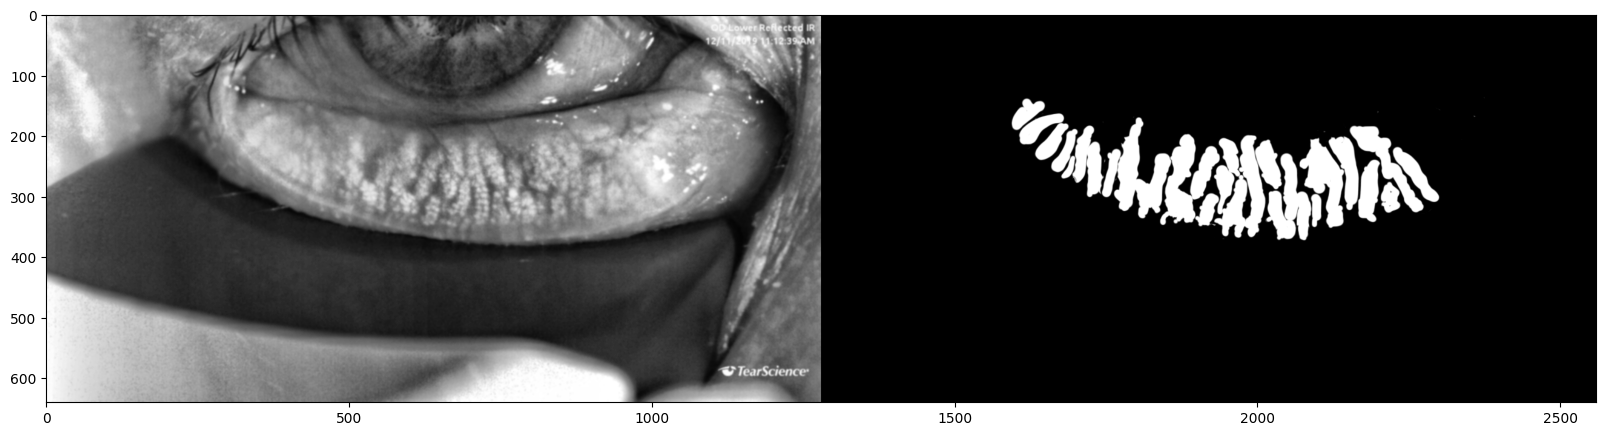

In [64]:

imshow(cv2.hconcat([img,img2]), cmap='gray')


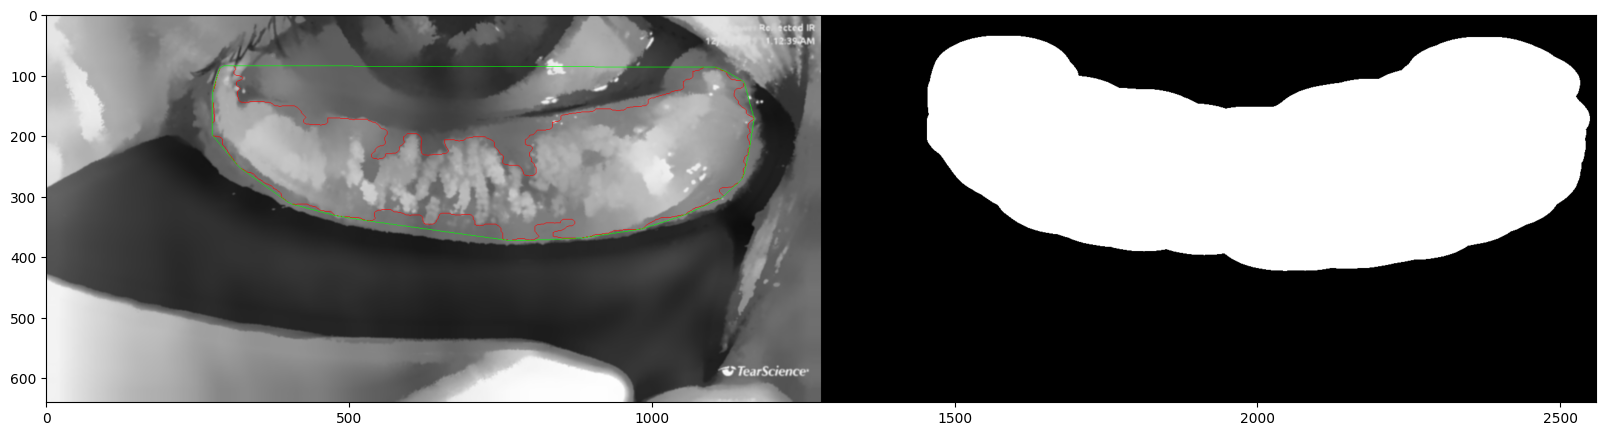

In [65]:

# Find ROI Mask
imshow(cv2.hconcat([res_cnt, cv2.cvtColor(mask_cnt3, cv2.COLOR_GRAY2BGR)]), cmap='gray')


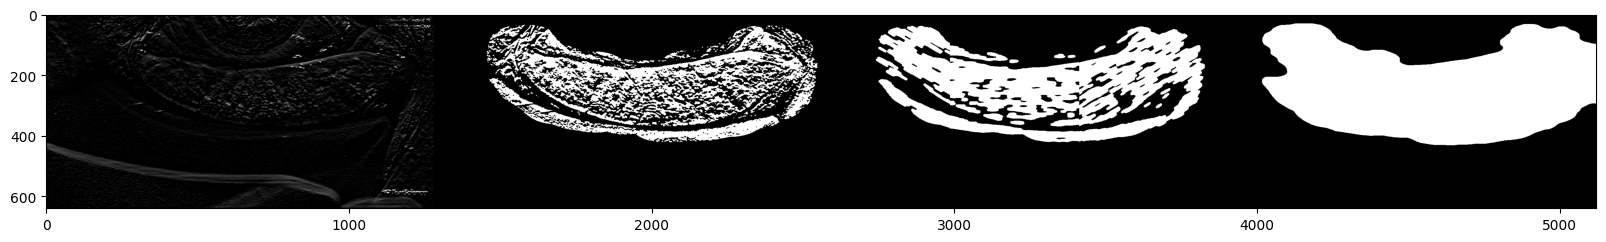

In [66]:
imshow(cv2.hconcat([res_sbl, res_sbl_mor, res_sbl_mor3, mask_cnt_fin]), cmap='gray')
# Improve ROI Mask

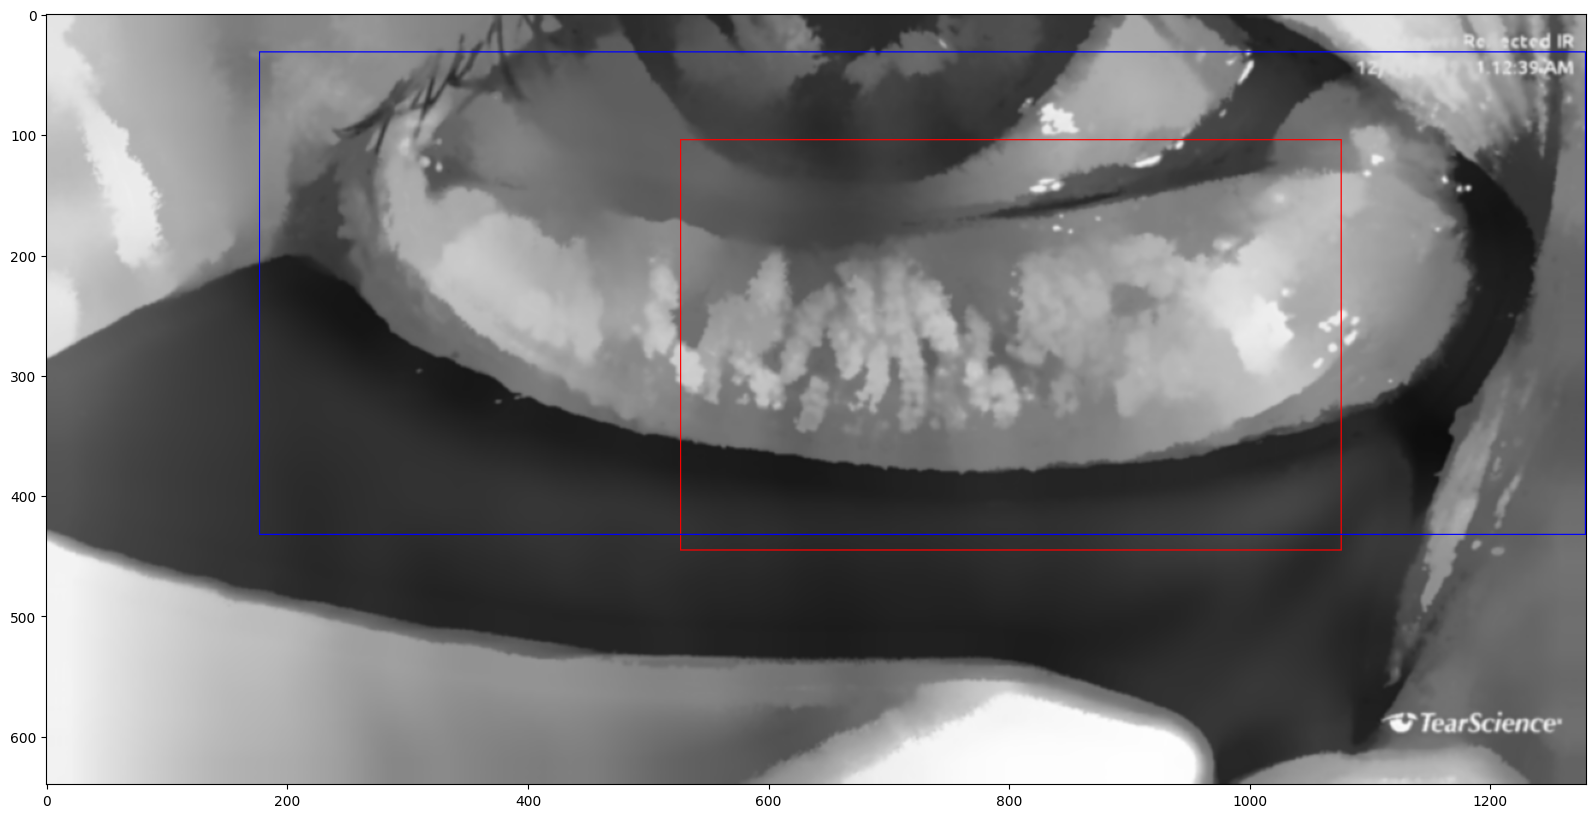

In [67]:
imshow(img_bbox)

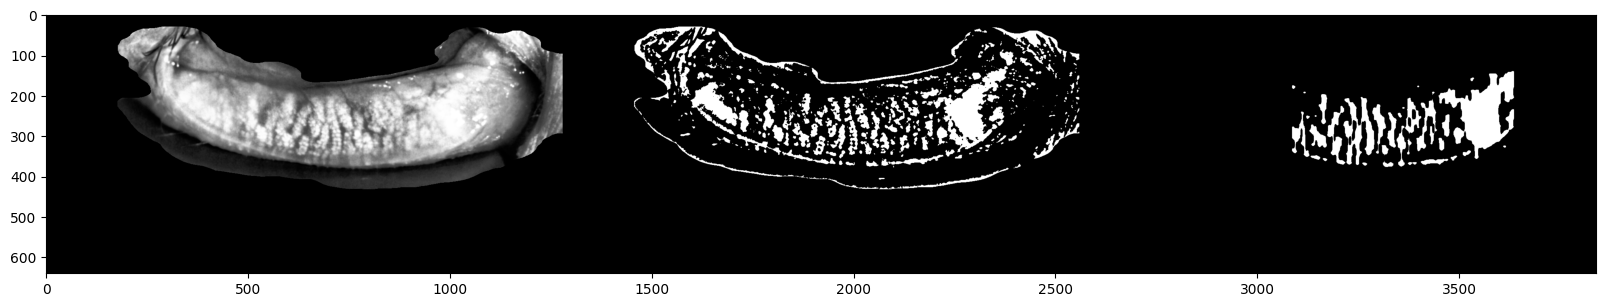

In [68]:
imshow(cv2.hconcat([res_histeq, res_athr_histeq, res_candidate_glands]), cmap='gray')

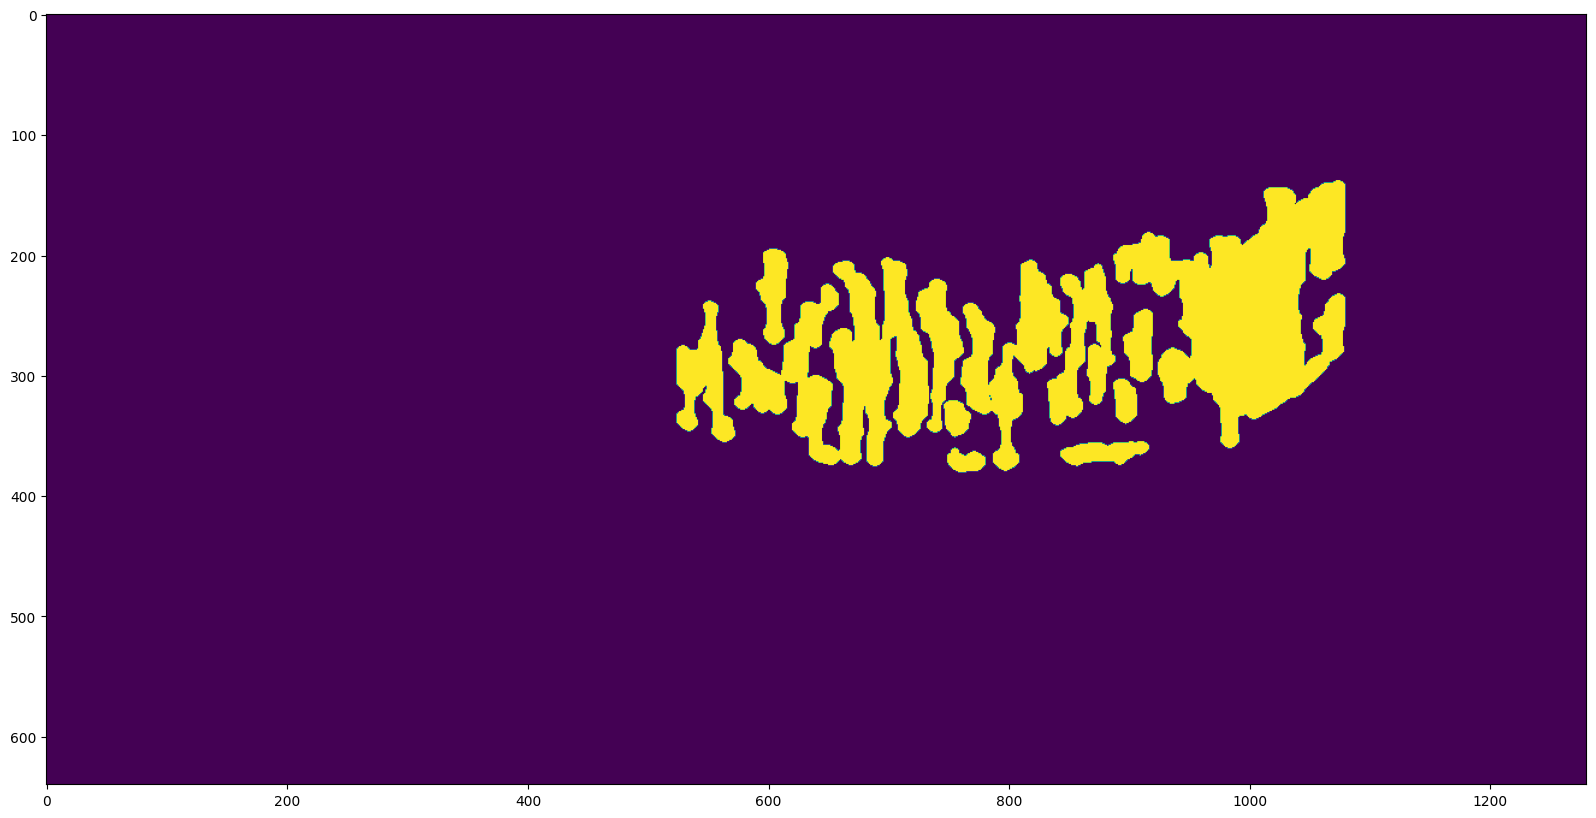

In [69]:

imshow(img1)

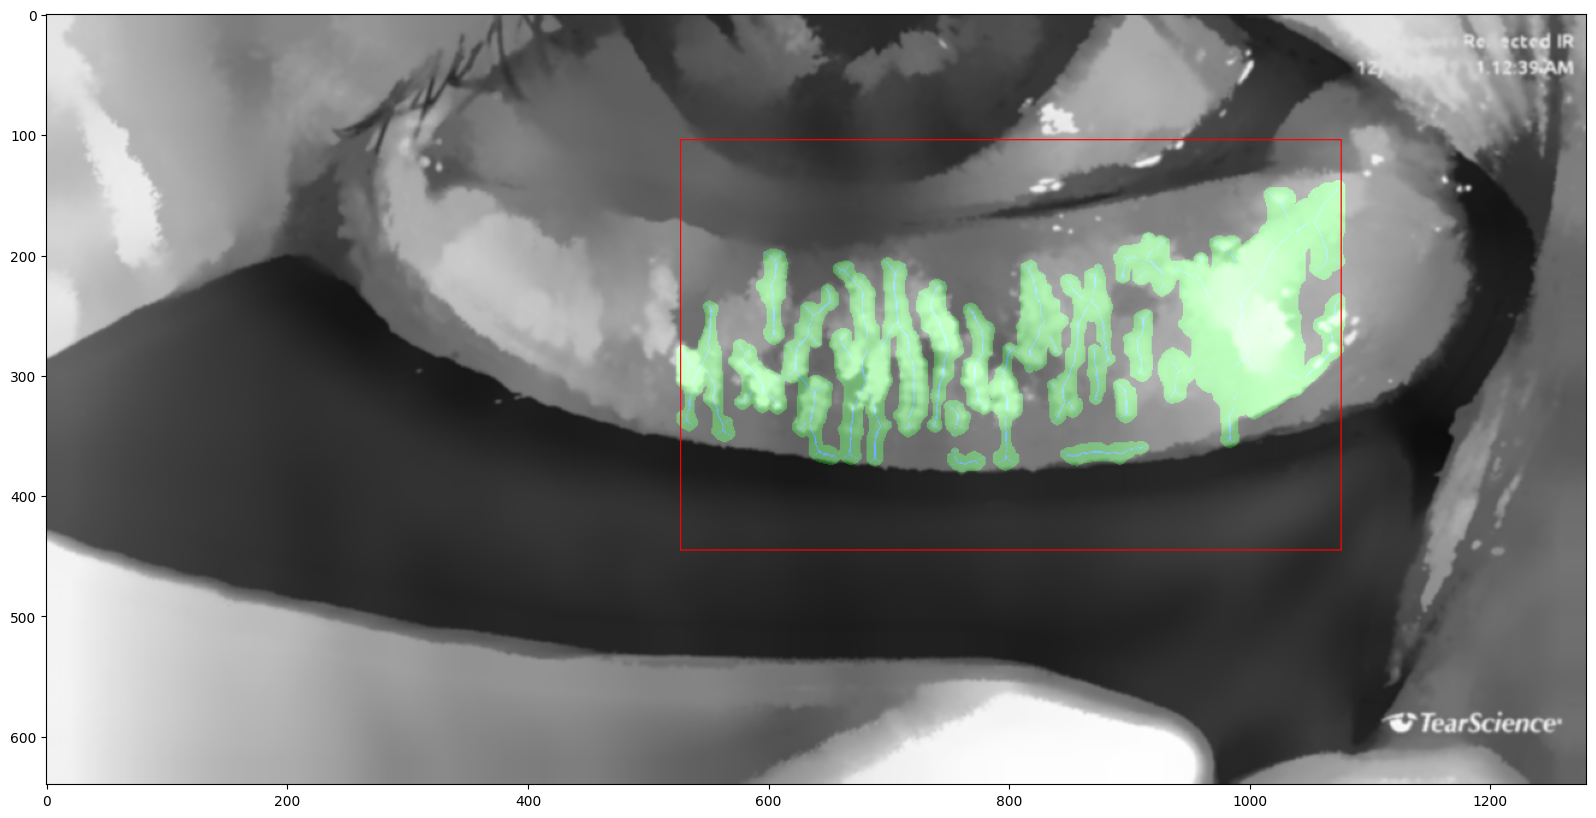

In [70]:
imshow(img_res)

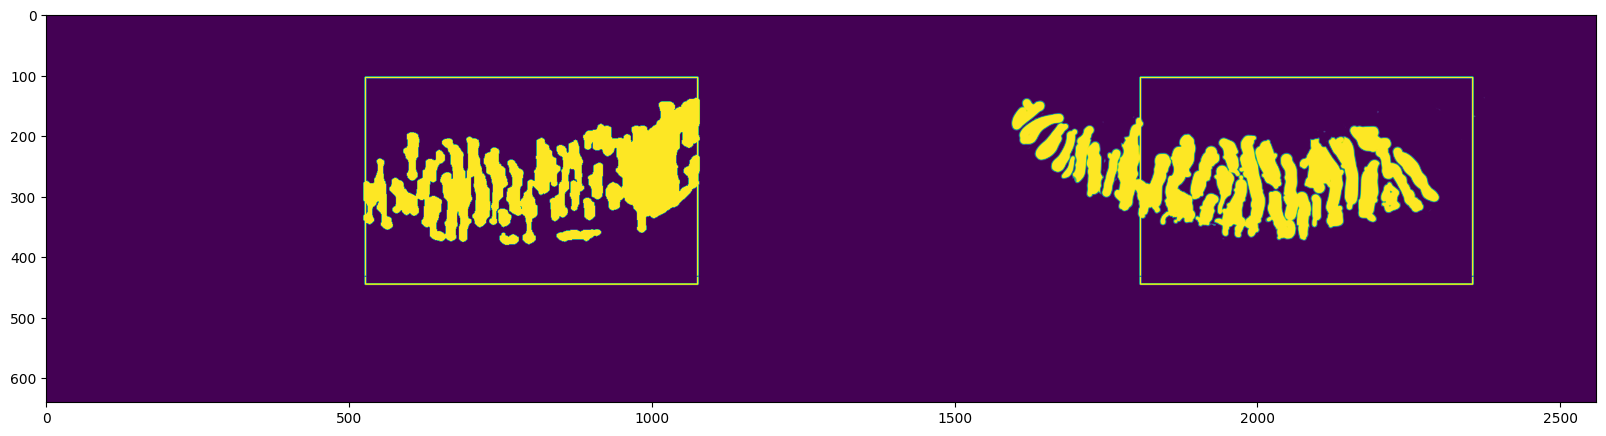

In [71]:

imshow(cv2.hconcat([img_bbox1,img_bbox2]))
# Create mask based on bbox_small

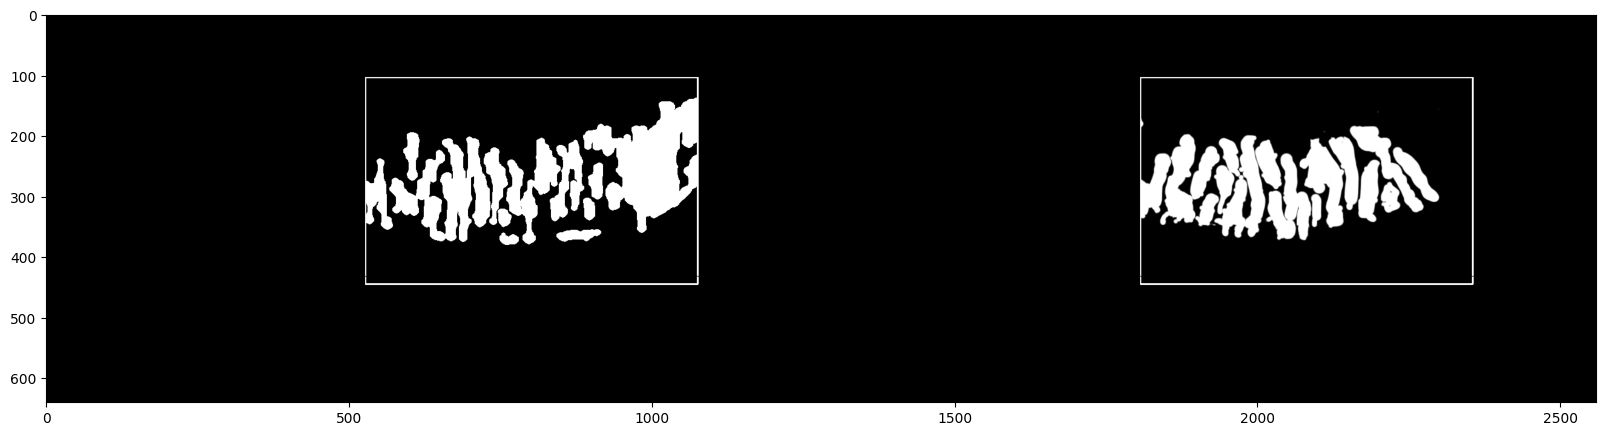

In [72]:
imshow(cv2.hconcat([imgcr1, imgcr2]), cmap='gray')

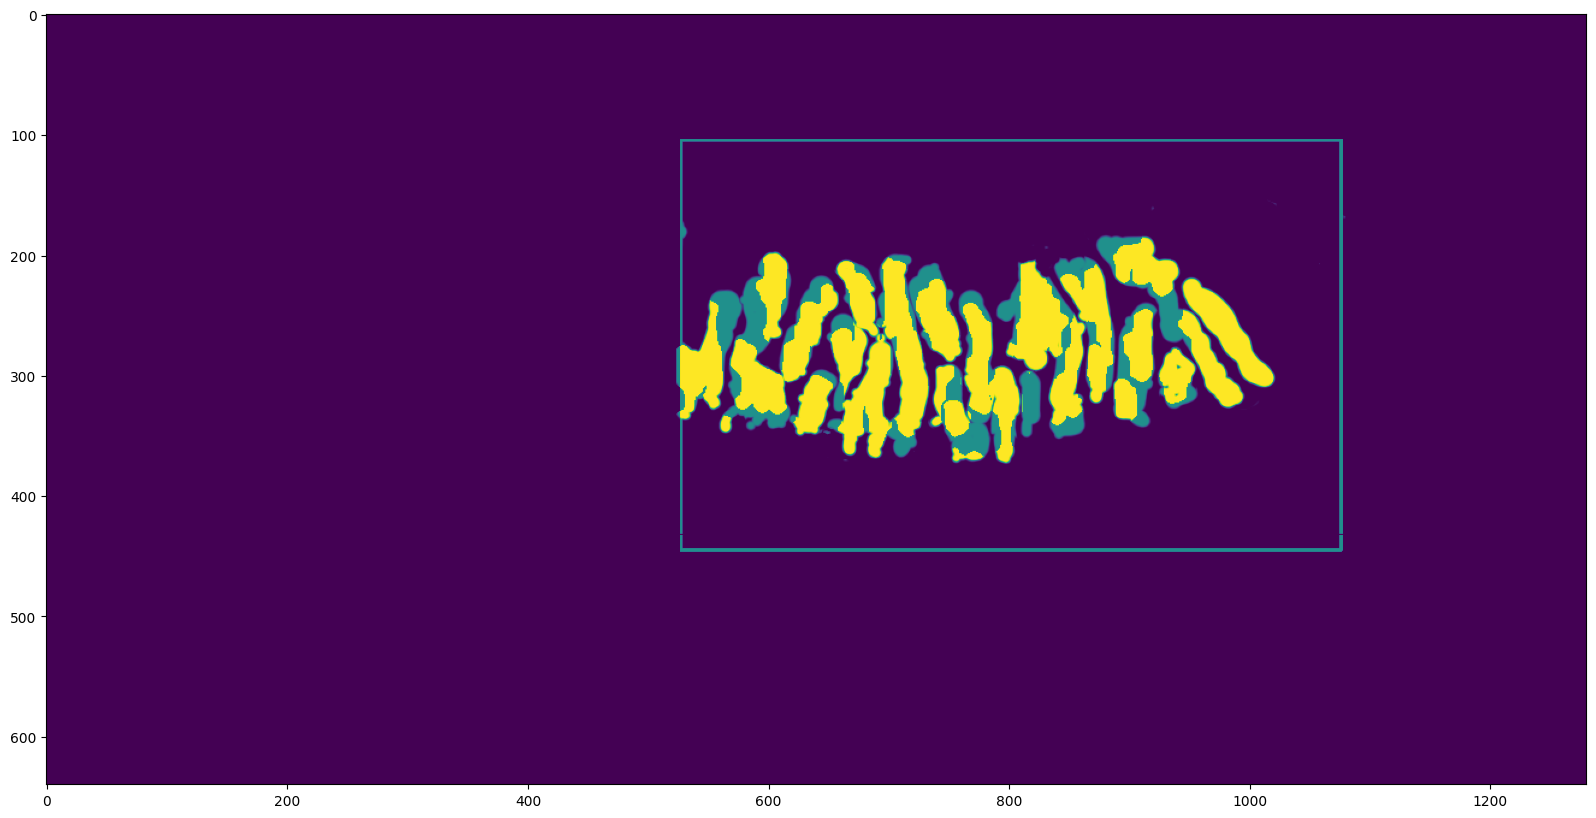

In [73]:
imshow(overlay_image)

In [74]:
print("Matching score pixel by pixel: {:.2f}%".format(score))

Matching score pixel by pixel: 71.50%


In [75]:
calculation_report(res_glands,mask_box,mask_cnt_fin,res_dict,img_no)

--- SAMPLE IMAGE 10 ---
- Total gland intensity(%)       :  36.31980221088876
- Average gland length(px)       :  76.90461708517635
- Standard dev of length(px)     :  54.105780776843844
- Average gland thickness(px)    :  28.39103471991214
- Avg of stdev of thickness(px)  :  10.809037773409111
- Avg of tortuosities(ratio)     :  2.362953900305508
-----------------------

